# 1.5: Monte Carlo uncertainty estimation #

We now repeat the uncertainty analysis of the curve fitting question but instead use Monte
Carlo error propagation. This practical is intended as a demonstration of how analytical expressions for model covariance matrices and related quantities such as confidence intervals, can also be determined from Monte Carlo error propagation. While in linear problems these results should be approximately equal the Monte Carlo method can equally be applied in nonlinear cases.

Recall that the problem is to
fit the following function to some observations of
$x_i, y_i, (i=1\dots,N)$

$$ y(x) = \frac{1}{100}\left[ \frac{m_1}{5} + \frac{m_2}{5}x +\frac{m_3}{16}(x^2 + 1600\sin(\frac{x}{2\pi})) \right ]. $$

<img src="../../Figures/Example-data-curve.png" alt="Example of test data for regression problem with true curve (blue). Here the $x$ values are generated uniformly randomly between 0 and 120, while the $y$ values are equal to the curve height plus a Gaussian random error with $\sigma_y = 0.75$, i.e. $y_{obs} = y_{true} + \epsilon$, where $\epsilon \sim N(0, \sigma_y^2)$." width="600"/>

Figure 1. Example of test data for regression problem with true curve (blue). Here the $x$ values are generated uniformly randomly between 0 and 120, while the $y$ values are equal to the curve height plus a Gaussian random error with $\sigma_y = 0.75$, i.e. $y_{obs} = y_{true} + \epsilon$, where $\epsilon \sim N(0, \sigma_y^2)$.



First load some libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pickle
import sys
sys.path.append("../software")
import plotcovellipse as pc

As before we read in a data set of 12 value for this curve and plot them.

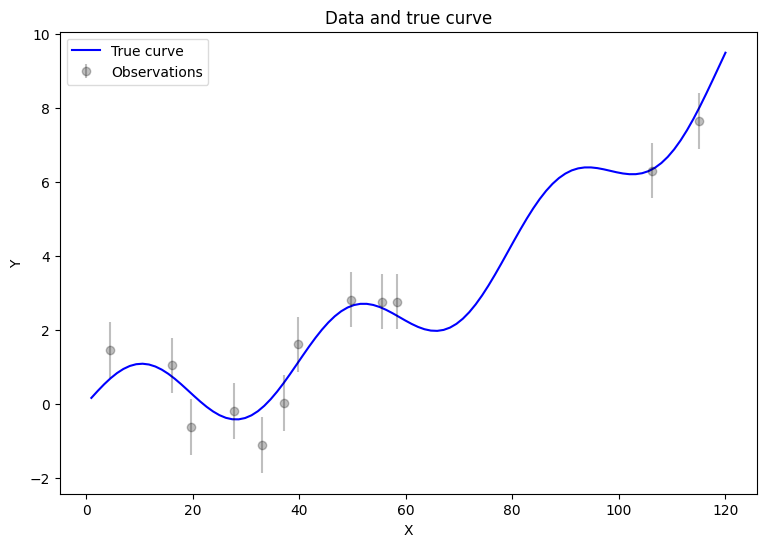

In [2]:
xmin, xmax, nres = 1.0, 120.0, 100
#
# read in observations
#
pickle_off = open("../datasets/data_fitting.pickle","rb")
[yobs,xobs,x_true,y_true] = pickle.load(pickle_off)
sigmay = 0.75

# ----------------------------------------------------------------------------   
# plot data
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(x_true, y_true,label='True curve',color='b')
ax.errorbar(xobs,yobs,yerr=sigmay,fmt='o',color=(0, 0, 0, 0.25),label='Observations')
plt.legend(loc='upper left',framealpha=0.7)
plt.title('Data and true curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


As a preliminary step you will need to repeat the calculation of G matrix, Least squares solution and model covariance matrix done previously for this dataset. You can cut and paste your previous solution below.

In [3]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# You can cut and paste your previous solution here

# Calculate G_fine
G_fine = np.transpose([np.ones(len(x_true))/500., x_true/500., 0.5*x_true*x_true/800.+1.0*np.sin(x_true/(2.0*np.pi)),])
G = np.transpose([np.ones(len(xobs))/500., xobs/500., xobs*xobs/1600.+1.0*np.sin(xobs/(2.0*np.pi)),]) # G matrix
# G matrix

sigmay = 0.75 # Standard deviation of noise
ndata = len(yobs) # Number of data

Cdinv = np.eye(ndata)/(sigmay**2) # Inverse Data covariance matrix

In [4]:
# lets define a routine for the least squares solution
def LSsolver(y,G,Cdinv):
    A = np.dot(np.transpose(G), Cdinv)
    GtG = np.dot(A, G) # G^T C_inv G^T
    GtGinv = np.linalg.inv(GtG) # Inverse of G^TC_inv G
    B = np.dot(A,y)
    mls = np.dot(GtGinv, B) # Least squares solution 
    return mls,GtGinv


Covariance matrix
 [[ 6.68612564e+04 -2.12555457e+03  4.51997063e+01]
 [-2.12555457e+03  9.50982919e+01 -2.36870998e+00]
 [ 4.51997063e+01 -2.36870998e+00  6.68547844e-02]]

 Solution and 95% Confidence intervals 
 Parameter 1 208.423 [-298.384, 715.231]
 Parameter 2  -8.867 [-27.980,  10.247]
 Parameter 3   1.247 [  0.740,   1.754]


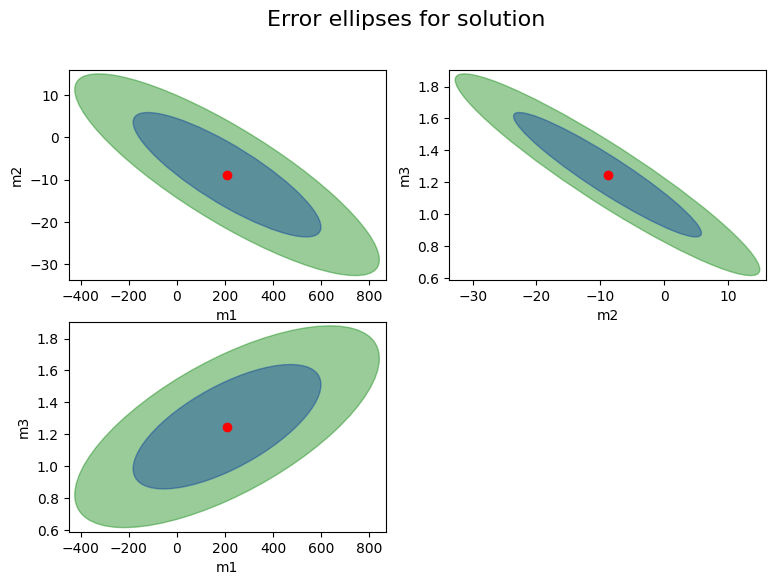

In [5]:
# Least squares solution

mls, GtGinv = LSsolver(yobs,G,Cdinv)

ypredicted = np.dot(G_fine,mls) # predicted y values from least squares solution
  
# Model covariance matrix and its projections

Cm = GtGinv # Covariance matrix of solution errors
print("Covariance matrix\n",Cm)

#Corr = Cm 
D = np.sqrt(np.diag(Cm)) 
Dinv = np.linalg.inv(np.diag(D))
#Corr = np.dot(Dinv,np.dot(Cm,Dinv)) #  Correlation matrix of solution errors
#print("\nCorrelation matrix\n",Corr)

sig_param1 = np.sqrt(Cm[0,0])
sig_param2 = np.sqrt(Cm[1,1])
sig_param3 = np.sqrt(Cm[2,2])
print("\n Solution and 95% Confidence intervals ")
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[0],mls[0]-1.96*sig_param1,mls[0]+1.96*sig_param1))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[1],mls[1]-1.96*sig_param2,mls[1]+1.96*sig_param2))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[2],mls[2]-1.96*sig_param3,mls[2]+1.96*sig_param3))

# ----------------------------------------------------------------------------
# Plot covariance matrix from error distribution for each pair of solution parameters
# ----------------------------------------------------------------------------

pc.plot_conf_ellipses(mls,Cm)

**Task 1:** 
To perform the Monte Carlo error propagation we generate Gaussian random deviates with standard deviation
    $\sigma_y = 0.75$ as was assumed previously. Add these to the
    observed y values $y_{obs}$. Then use these new y values and fit the
    model in Figure 1 as many times as you think necessary. Make a 2-D scatter plots of pairs of parameters in the MC solutions and compare to the linear covariance ellipses you plotted previously.
    

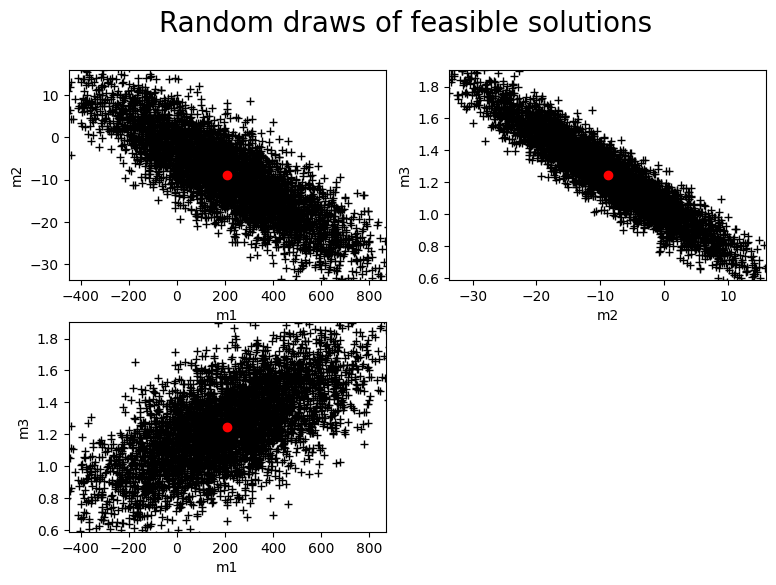

In [6]:
# ----------------------------------------------------------------------------
# Monte Carlo estimate of feasible solutions
# ----------------------------------------------------------------------------

# Perform Monte Carlo error analysis

MCsols=[]
for i in range(5000):
    yMC= yobs +sigmay*np.random.randn(ndata)
    mlsMC = LSsolver(yMC,G,Cdinv)[0]
    MCsols.append(mlsMC)
MCsols=np.array(MCsols)    

pc.plot_feasible(mls,Cm,MCsols)

**Task 2:** Plot the histogram of the Monte Carlo solutions for each parameter
    $m_1,m_2$ and $m_3$. How do they compare to the 95% confidence
    intervals calculated previously? Do the marginal distributions look reasonable? How do you know this?

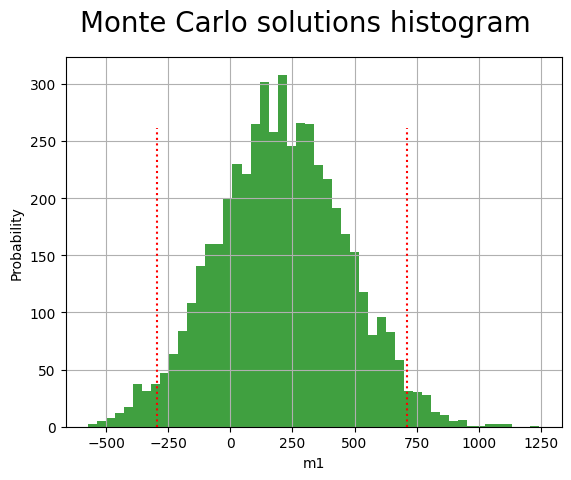

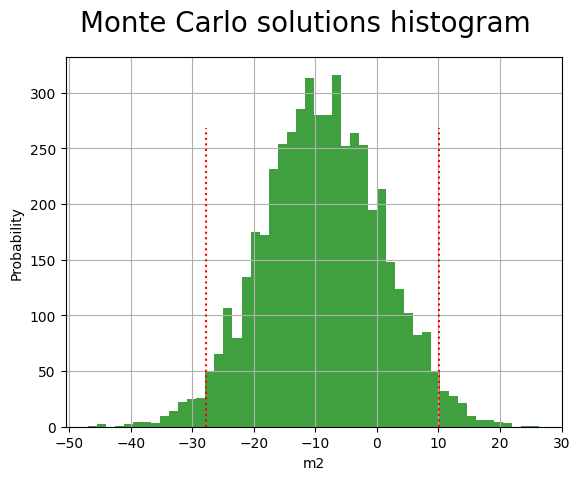

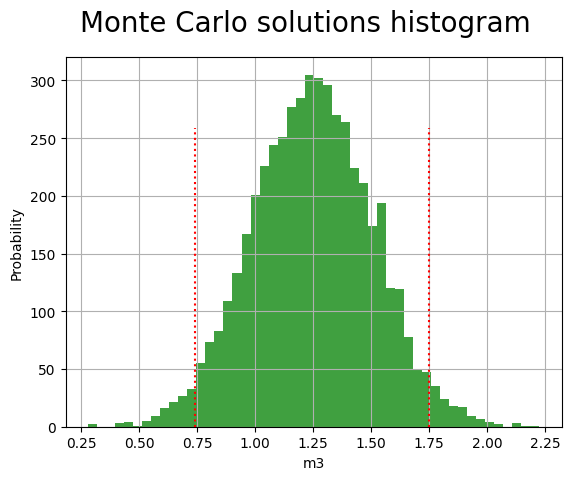

In [7]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Write your answer in here

pc.plot_marginal_histograms(mls,MCsols)

**Task 3:** Calculate a model covariance matrix from the MC solutions and
    compare to the model covariance matrix values found in Q1.5 above.
    Plot ellipses for pairs of parameters, as before. How do these plots
    compare to the covariance ellipses you plotted previously based on analytical formulae for model covariance?

 Monte Carlo estimate of covariance matrix
 [[ 6.60025521e+04 -2.06173055e+03  4.35509957e+01]
 [-2.06173055e+03  9.30614925e+01 -2.33312888e+00]
 [ 4.35509957e+01 -2.33312888e+00  6.63795421e-02]]
 Previously Calculated covariance matrix
 [[ 6.68612564e+04 -2.12555457e+03  4.51997063e+01]
 [-2.12555457e+03  9.50982919e+01 -2.36870998e+00]
 [ 4.51997063e+01 -2.36870998e+00  6.68547844e-02]]


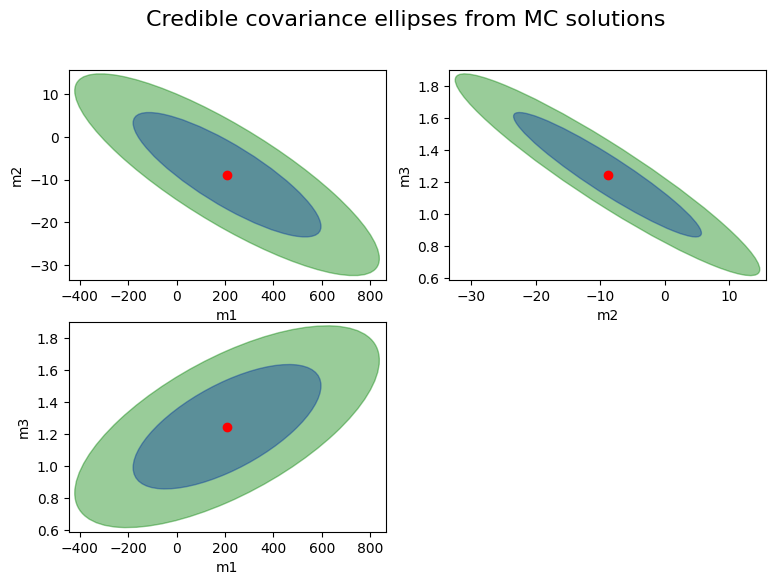

In [8]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

l68 = np.sqrt(stats.chi2.ppf(q=0.68,df=2)) # number of standard deviations equivalent to 68% confidence ellipse
l95 = np.sqrt(stats.chi2.ppf(q=0.95,df=2)) # number of standard deviations equivalent to 95% confidence ellipse

MCcov = np.cov(MCsols.T)
print(' Monte Carlo estimate of covariance matrix\n',MCcov)

print(' Previously Calculated covariance matrix\n',Cm)

pc.plot_conf_ellipses(mls,MCcov,"Credible covariance ellipses from MC solutions",CIs=[l68,l95])

**Task 4:** Calculate 95% confidence intervals for each parameter using your MC
    estimated model covariance matrix. How do these results compare to
    the ones you obtained with linear theory?

In [9]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Write your answer in here
print("\n Solution and Calculated 95% Confidence intervals ")
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[0],mls[0]-1.96*sig_param1,mls[0]+1.96*sig_param1))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[1],mls[1]-1.96*sig_param2,mls[1]+1.96*sig_param2))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[2],mls[2]-1.96*sig_param3,mls[2]+1.96*sig_param3))
sig_param1mc = np.sqrt(MCcov[0,0])
sig_param2mc = np.sqrt(MCcov[1,1])
sig_param3mc = np.sqrt(MCcov[2,2])
print("\n Solution and Monte Carlo estimated 95% Confidence intervals ")
print(" Parameter 1 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[0],mls[0]-1.96*sig_param1mc,mls[0]+1.96*sig_param1mc))
print(" Parameter 2 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[1],mls[1]-1.96*sig_param2mc,mls[1]+1.96*sig_param2mc))
print(" Parameter 3 {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[2],mls[2]-1.96*sig_param3mc,mls[2]+1.96*sig_param3mc))



 Solution and Calculated 95% Confidence intervals 
 Parameter 1 208.423 [-298.384, 715.231]
 Parameter 2  -8.867 [-27.980,  10.247]
 Parameter 3   1.247 [  0.740,   1.754]

 Solution and Monte Carlo estimated 95% Confidence intervals 
 Parameter 1 208.423 [-295.119, 711.966]
 Parameter 2  -8.867 [-27.774,  10.041]
 Parameter 3   1.247 [  0.742,   1.752]


**Task 5**
Calculate feasible curves corresponding to your Monte Carlo solutions and plot them together with the actual best fit curve. Does this figure look similar to the one you obtained with linear theory?

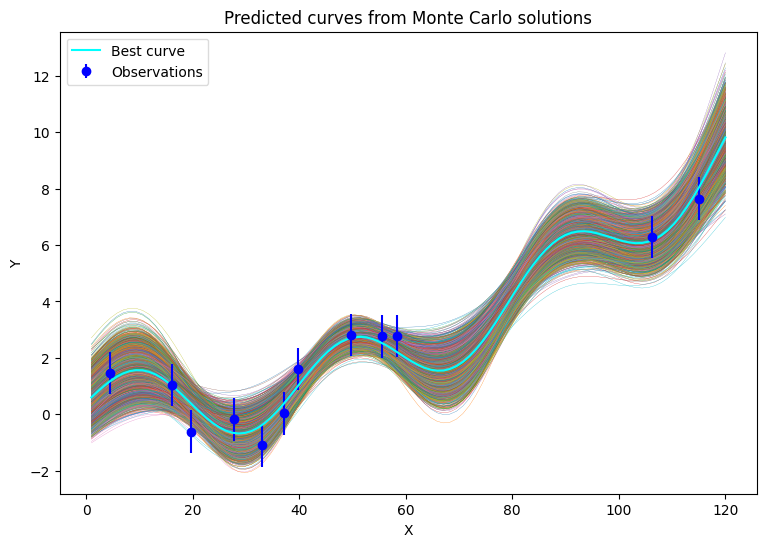

In [10]:
s = np.dot(G_fine,np.transpose(MCsols))

# ----------------------------------------------------------------------------
# Plot predicted polynomials for Monte Carlo solutions
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x_true,s,lw=0.2)
ax.errorbar(xobs,yobs,yerr=sigmay,fmt='o',color='b',label='Observations')
plt.title('Predicted curves from Monte Carlo solutions')
ax.plot(x_true, ypredicted,label='Best curve',color='cyan')
plt.legend(loc='upper left',framealpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()